### Objective of the notebook:

We will add day differences between consecutive orders and calculate rolling features in 3 days, 1, 2, 4, 12, 24 weeks.

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm 

from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore") 

kfold = KFold(n_splits=5, random_state=42)
break_point = datetime(2017, 2, 28)

/Users/kaan.simsek/anaconda3/envs/forecasting/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### Importing datasets

In [2]:
def read_data():
    
    print('Reading files...')    
    order_df = pd.read_csv('../input/machine_learning_challenge_order_data.csv')
    print('Order data has {} rows and {} columns'.format(order_df.shape[0], order_df.shape[1]))
    label_df = pd.read_csv('../input/machine_learning_challenge_labeled_data.csv')
    print('Label data has {} rows and {} columns'.format(label_df.shape[0], label_df.shape[1]))
    df = order_df.merge(label_df, on='customer_id')
    print('The final data has {} rows and {} columns'.format(df.shape[0], df.shape[1]))
    print("")
    return df

### Change data types and reduce memory usage

In [3]:
def reduce_mem_usage(df, verbose=False):
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

### Label encode categorical features

In [4]:
def transform_data(df):

    labelencoder = LabelEncoder()

    for i in ['restaurant_id', 'city_id', 'payment_id', 'platform_id', 'transmission_id']:
        df[i] = labelencoder.fit_transform(df[i])

    return df

### Convert raw data to a session format
- Fill order rank with the forward-filling method. 
- Calculate recency and number of days from the first order.
- Get time-related features like the year, month, week, day, day of the week, weekend.
- Add day differences between consecutive orders. 
- Calculate rolling features in 3 days, 1, 2, 4, 12, 24 weeks, and all time.
- Keep the last record of each customer.

In [5]:
def getWeeklyDates(df, break_point):

    df['order_date'] = pd.to_datetime(df['order_date'])
    three_day = df[df['order_date'] >= break_point - timedelta(days=3)]
    one_week = df[df['order_date'] >= break_point - timedelta(days=7)]
    two_week = df[df['order_date'] >= break_point - timedelta(days=14)]
    four_week = df[df['order_date'] >= break_point - timedelta(days=28)]
    twelve_week = df[df['order_date'] >= break_point - timedelta(days=84)]
    twenty_four_week = df[df['order_date'] >= break_point - timedelta(days=168)]
    all_week = df
    return three_day, one_week, two_week, four_week, twelve_week, twenty_four_week,all_week

In [6]:
def feature_engineering(df, break_point):
    
    df['customer_order_rank'] = df['customer_order_rank'].fillna(method='ffill')

    df['order_date'] = pd.to_datetime(df['order_date']) 
    df['recency'] = (break_point - df['order_date']) / np.timedelta64(1, 'D')
    df['first_order_date'] = df.groupby(['customer_id'])['order_date'].transform('first')
    df['age_of_user'] = (break_point - df['first_order_date']) / np.timedelta64(1, 'D')

    df['year'] = df['order_date'].dt.year
    df['month'] = df['order_date'].dt.month
    df['week'] = df['order_date'].dt.week
    df['day'] = df['order_date'].dt.day
    df['dayofweek'] = df['order_date'].dt.dayofweek
    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(np.int8)
    
    df['demand'] = 1
    
    df['order_date_shift'] = df.groupby('customer_id')['order_date'].shift()
    df['date_diff'] = (df['order_date'] - df['order_date_shift']) / np.timedelta64(1, 'D')

    three_day, one_week, two_week, four_week, twelve_week, twenty_four_week,all_week = getWeeklyDates(df, break_point)
    
    col = ['demand', 'is_failed','voucher_amount','delivery_fee', 'amount_paid', 'date_diff']
    three_day, one_week, two_week, four_week, twelve_week, twenty_four_week,all_week = getWeeklyDates(df, break_point)
    three_day = three_day.groupby('customer_id')[col].mean().add_prefix('three_day_').reset_index()
    one_week = one_week.groupby('customer_id')[col].mean().add_prefix('one_week_').reset_index()
    two_week = two_week.groupby('customer_id')[col].mean().add_prefix('two_week_').reset_index()
    four_week = four_week.groupby('customer_id')[col].mean().add_prefix('four_week_').reset_index()
    twelve_week = twelve_week.groupby('customer_id')[col].mean().add_prefix('twelve_week_').reset_index()
    twenty_four_week = twenty_four_week.groupby('customer_id')[col].mean().add_prefix('twenty_four_week_').reset_index()
    all_week = all_week.groupby('customer_id')[col].mean().add_prefix('all_week_').reset_index()
    
    df = df.merge(three_day, how='left').merge(one_week, how='left').merge(two_week, how='left').merge(four_week,
    'left').merge(twelve_week,'left').merge(twenty_four_week,'left').merge(all_week,'left').reset_index()

    df = df.groupby('customer_id').last().reset_index()

    return df

### Run the lgb model and calculate scores

We give more weights on class 1 using scale the pos weight parameter to label returned customers more correctly.

In [7]:
def run_lgb(df):
    
    y = df['is_returning_customer']
    X = df.drop(columns=['index', 'customer_id', 'order_date', 'is_returning_customer',
                        'first_order_date', 'order_date_shift'])    
    
    clf = lightgbm.LGBMClassifier(n_jobs= -1, scale_pos_weight=2)
    clf.fit(X, y)

    y_pred = cross_val_predict(clf, X, y, cv=kfold)
    
    fig, (ax0,ax1) = plt.subplots(2,1, figsize=(10,14))

    sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='2.0f', ax=ax0).set_title('Confusion matrix')

    pd.Series(clf.feature_importances_,X.columns).sort_values()[-20:].plot.barh(width=0.8, 
                                        color='navy', ax=ax1).set_title('Feature Importance')

    print('Accuracy Score:  ', round(metrics.accuracy_score(y, y_pred), 3))
    print('Roc Auc Score:  ', round(roc_auc_score(y, y_pred), 3))
    print("")
    print('Classification Report: \n', classification_report(y, y_pred, target_names=['0', '1']))

### Execute all pipeline

The accuracy and roc-auc scores are 0.83 and 0.73 relatively. Adding features increase model scores by 1%.

Reading files...
Order data has 786600 rows and 13 columns
Label data has 245455 rows and 2 columns
The final data has 786600 rows and 14 columns

Mem. usage decreased to 42.76 Mb (52.5% reduction)
Accuracy Score:   0.826
Roc Auc Score:   0.734

Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.90      0.89    189948
           1       0.63      0.57      0.59     55507

   micro avg       0.83      0.83      0.83    245455
   macro avg       0.75      0.73      0.74    245455
weighted avg       0.82      0.83      0.82    245455



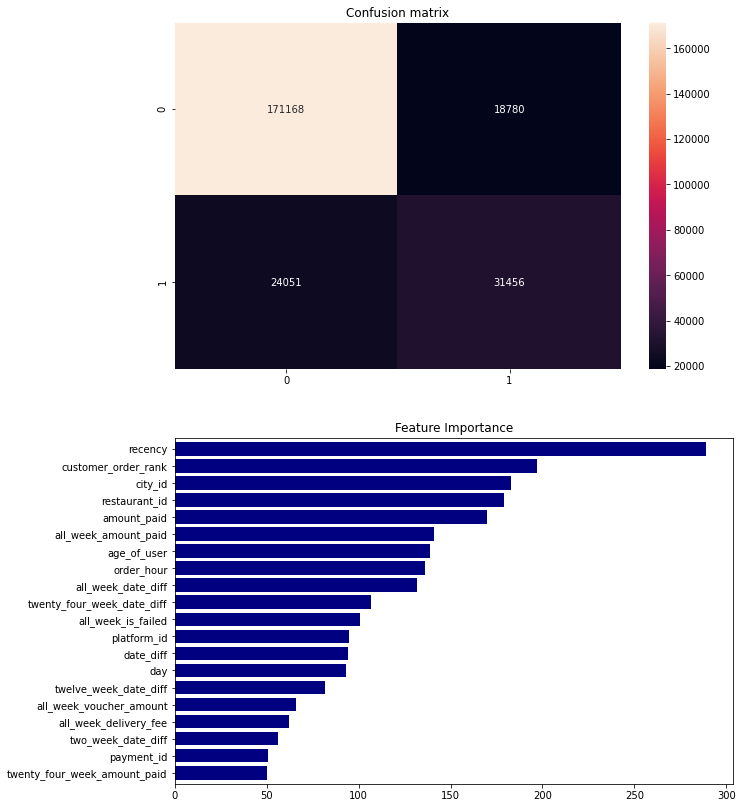

In [8]:
def execute_pipeline():
    
    df = read_data()
    df = reduce_mem_usage(df, True)
    df = transform_data(df)
    df = feature_engineering(df, break_point)
    run_lgb(df)

execute_pipeline()